Plan
1. Read
2. Look at the images
2. Simple benchmark model for the whole image
2. Preprocess the same way as in test set
3. Learn to predict type of alter
4. CNN for processed data to classify camera

Options: add PCA analysis

## Load and take a look at the data

In [1]:
import os
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt

In [2]:
input_path = 'input/'
train_path = os.path.join(input_path,'train')
test_path = os.path.join(input_path,'test')
cameras = os.listdir(train_path)

# for train set load camera models and filenames to dataframe with two columns: filename and camera model
train_images = []
for camera in cameras:
    for fname in sorted(os.listdir(os.path.join(train_path, camera))):
        train_images.append((camera, os.path.join(train_path, camera, fname)))

train = pd.DataFrame(train_images, columns=['camera', 'fname'])
print("There are {} images in train dataset".format(len(train)))

# for test set load filenames to a vector, then create a dataframe with two columns: filename and boolean value if 
# the image was altered
test_filenames = []
for fname in sorted(os.listdir(test_path)):
        test_filenames.append(os.path.join(test_path, fname))
        
test = pd.DataFrame(test_filenames, columns=['fname'])
test['altered'] = test['fname'].map(lambda x: 1 if 'manip' in x else 0)
      
print("There are {} images in test dataset: {} unchanged and {} manipulated".format(len(test),
                                                                                   len(test[test['altered'] == 0]),
                                                                                   len(test[test['altered'] == 1])))

There are 2750 images in train dataset
There are 2640 images in test dataset: 1320 unchanged and 1320 manipulated


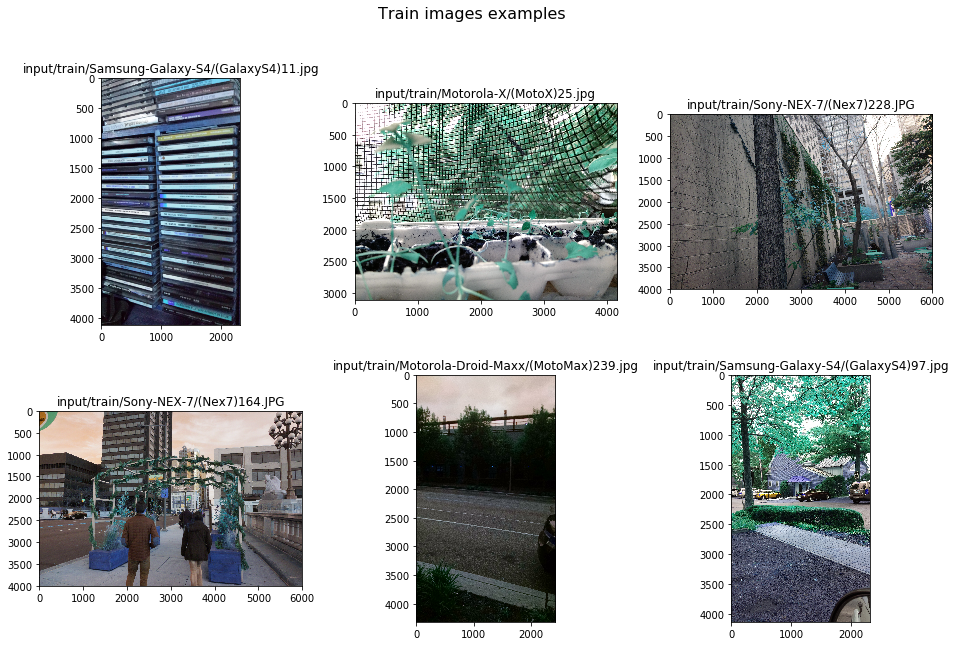

In [3]:
# take a look at the images
N = 6
random_idx_train = np.random.randint(0, len(train), N)

fig = plt.figure(figsize=(16,10))
for i in range(N):
    img = cv2.imread(train.iloc[random_idx_train[i]]['fname'])
    ax = fig.add_subplot(2, 3, i + 1) # two rows, one column, i plot
    plt.imshow(img)
    plt.title(train.iloc[random_idx_train[i]]['fname'])

plt.suptitle('Train images examples', fontsize=16)
plt.show()
plt.tight_layout()

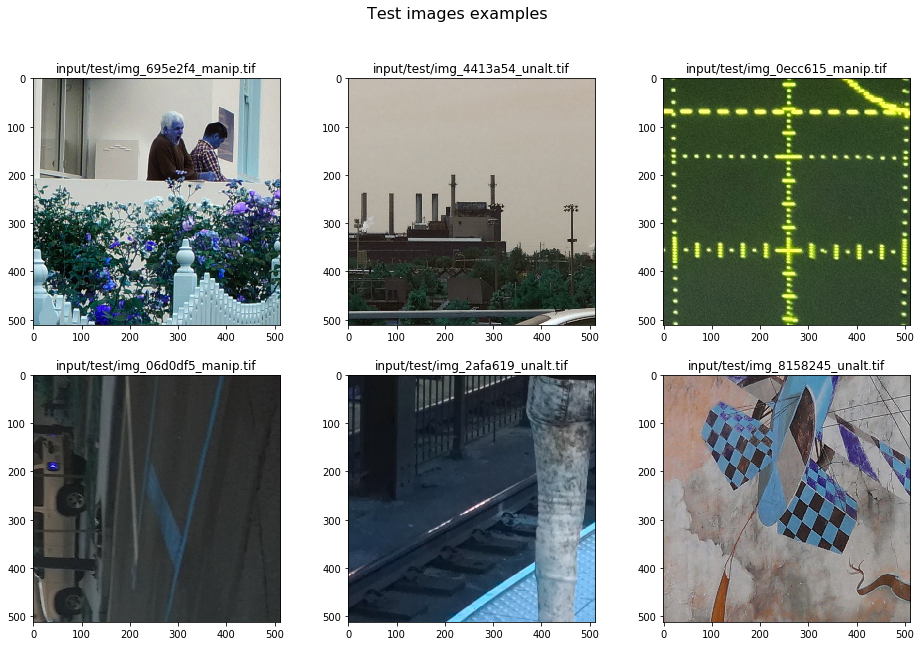

In [4]:
random_idx_test = np.random.randint(0, len(test), N)
fig = plt.figure(figsize=(16,10))
for i in range(N):
    img = cv2.imread(test.iloc[random_idx_test[i]]['fname'])
    ax = fig.add_subplot(2, 3, i + 1) # two rows, one column, i plot
    plt.imshow(img)
    plt.title(test.iloc[random_idx_train[i]]['fname'])

plt.suptitle('Test images examples', fontsize=16)
plt.show()
plt.tight_layout()

## Simple CNN benchmark

In [5]:
from sklearn.model_selection import train_test_split

train_labels = pd.get_dummies(train['camera'])
X_train, X_test, y_train, y_test = train_test_split(train['fname'], train_labels, test_size=0.7, random_state=42, shuffle = True)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [20]:
from keras.preprocessing.image import ImageDataGenerator
from cv2 import imread

def batch_generator(X, y, batch_size):
    
    while True:
        images_list = []
        labels_list = []
        for i in range(batch_size):
            idx = np.random.randint(0, len(X))
            img_path = X.iloc[idx]
            label = y[idx]
            img = imread(img_path)
            img = cv2.resize(img,(512,512))
            images_list.append(img)
            labels_list.append(label)

        yield np.array(images_list), np.array(labels_list)

In [21]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalMaxPool2D, Concatenate
input_shape = (512, 512, 3)
nclass = y_train.shape[1]

def get_model():

    inp = Input(shape=input_shape)
    norm_inp = BatchNormalization()(inp)
    img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu, padding="same")(norm_inp)
    img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu, padding="same")(img_1)
    img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
    img_1 = Dropout(rate=0.2)(img_1)
    img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu, padding="same")(img_1)
    img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu, padding="same")(img_1)
    img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
    img_1 = Dropout(rate=0.2)(img_1)
    img_1 = Convolution2D(64, kernel_size=2, activation=activations.relu, padding="same")(img_1)
    img_1 = Convolution2D(20, kernel_size=2, activation=activations.relu, padding="same")(img_1)
    img_1 = GlobalMaxPool2D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)
    dense_1 = Dense(20, activation=activations.relu)(img_1)
    dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam()

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [ ]:
model = get_model()

checkpoint = ModelCheckpoint(out_model_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=1)
callbacks = [checkpoint, early] #early

out_model_path = 'simple_benchmark/CNN_5.hdf5'

epochs = 1
batch_size = 30

print('Start training...')
history = model.fit_generator(
        generator=batch_generator(X_train,y_train, batch_size),
        epochs=epochs,
        steps_per_epoch=100,
        validation_data=batch_generator(X_train,y_train, batch_size),
        validation_steps=100,
        verbose=2,
        callbacks=callbacks)

model.save_weights(out_model_path)
pd.DataFrame(history.history).to_csv('simple_CNN_5.csv', index=False)
print('Training is finished (weights simple_CNN_5.hdf5 and logs simple_CNN_5.csv are generated )...')
    
#history = model.fit(X_train, y, validation_split=0.1, epochs=10, shuffle=True, verbose=2,
#                              callbacks=callbacks_list)

#print(history)

#model.load_weights(file_path)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 512, 512, 3)       12        
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 512, 512, 16)      448       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 512, 512, 16)      2320      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 170, 170, 16)      0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 170, 170, 16)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 170, 170, 32)      4640      
__________

In [ ]:
out_model_path = 'simple_benchmark/CNN_5.h5'
epochs = 10
batch_size = 30
optim_type = 'Adam'
learning_rate = 0.001
model = get_model()

    # load from pretrained model
    pretrained_weights_path = 'zf_unet_224.h5'
    if os.path.isfile(pretrained_weights_path):
        model.load_weights(pretrained_weights_path)

    #optim = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
    optim = Adam(lr=learning_rate)
    model.compile(optimizer=optim, loss=dice_coef_loss, metrics=[dice_coef])
    model.summary()

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=patience, verbose=0),
        ModelCheckpoint('unet_224_temp.h5', monitor='val_loss', save_best_only=True, verbose=0),
    ]

    print('Start training...')
    history = model.fit_generator(
        generator=batch_generator(batch_size, 1),
        epochs=epochs,
        steps_per_epoch=100,
        validation_data=batch_generator(batch_size, 0),
        validation_steps=100,
        verbose=2,
        callbacks=callbacks)

    model.save_weights(out_model_path)
    pd.DataFrame(history.history).to_csv('unet_224_train.csv', index=False)
    print('Training is finished (weights unet_224.h5 and log unet_224_train.csv are generated )...')



Learn to predict type of alter